In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2

Paths

In [ ]:
BASE_DIR = "/content/drive/MyDrive/CMPE 593/datasets/NTHU-DDD"
OUTPUT_DIR = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Base:", BASE_DIR)
print("Output:", OUTPUT_DIR)

Base: /content/drive/MyDrive/CMPE 593/datasets/NTHU-DDD
Output: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD


File Name Parser

subjectID_accessory_scenario_frame_condition.jpg

example: 001_glasses_sleepyCombination_10_drowsy.jpg

In [ ]:
def parse_filename(filename):
    """
    Example filename:
    001_glasses_sleepyCombination_10_drowsy.jpg
    """
    name = filename.replace(".jpg", "").replace(".jpeg", "").replace(".png", "")
    parts = name.split("_")

    if len(parts) < 5:
        print("Unexpected filename format:", filename)
        return None

    return {
        "subject_id": parts[0],
        "accessory": parts[1],
        "scenario": parts[2],
        "frame_idx": parts[3],
        "condition_text": parts[4]  # text form (drowsy/notdrowsy)
    }


Loader Function

In [ ]:
def load_images_with_metadata(folder_path, numeric_label):
    file_paths = []
    labels = []
    metadata = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):

            parsed = parse_filename(filename)
            if parsed is None:
                continue

            file_paths.append(os.path.join(folder_path, filename))
            labels.append(numeric_label)
            metadata.append(parsed)

    return file_paths, labels, metadata


Load Drowsy & Not-Drowsy Folders

In [ ]:
drowsy_paths, drowsy_labels, drowsy_meta = load_images_with_metadata(
    os.path.join(BASE_DIR, "drowsy"),
    1   # label for drowsy
)

notd_paths, notd_labels, notd_meta = load_images_with_metadata(
    os.path.join(BASE_DIR, "notdrowsy"),
    0   # label for not drowsy
)

print("Drowsy:", len(drowsy_paths))
print("Not Drowsy:", len(notd_paths))


Drowsy: 36030
Not Drowsy: 30491


Merge Into a Single DataFrame

In [ ]:
all_paths = drowsy_paths + notd_paths
all_labels = drowsy_labels + notd_labels
all_meta   = drowsy_meta + notd_meta

df = pd.DataFrame(all_meta)
df["filepath"] = all_paths
df["label"] = all_labels

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()


,subject_id,accessory,scenario,frame_idx,condition_text,filepath,label
0,001,noglasses,nonsleepyCombination,1007,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/NTHU-...,0
1,005,noglasses,nonsleepyCombination,2023,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/NTHU-...,0
2,006,glasses,nonsleepyCombination,1356,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/NTHU-...,0
3,001,glasses,slowBlinkWithNodding,1836,drowsy,/content/drive/MyDrive/CMPE 593/datasets/NTHU-...,1
4,002,glasses,slowBlinkWithNodding,1362,drowsy,/content/drive/MyDrive/CMPE 593/datasets/NTHU-...,1


Train/Val/Test Split (Stratified)

In [ ]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    random_state=42,
    stratify=df["label"]
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=temp_df["label"]
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 46564
Validation size: 9978
Test size: 9979


Save Resized Images

In [ ]:
IMG_SIZE = 224  # for MobileNet/ResNet/EfficientNet

def save_resized_images(df, split_name):
    split_dir = os.path.join(OUTPUT_DIR, split_name)
    os.makedirs(split_dir, exist_ok=True)

    # class folders
    for cls in ["drowsy", "notdrowsy"]:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Saving {split_name}"):
        img = cv2.imread(row["filepath"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        class_name = "drowsy" if row["label"] == 1 else "notdrowsy"
        filename = os.path.basename(row["filepath"])

        save_path = os.path.join(split_dir, class_name, filename)
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))


Apply Preprocessing to Each Split

In [ ]:
save_resized_images(train_df, "train")
save_resized_images(val_df, "val")
save_resized_images(test_df, "test")

Saving test: 100%|██████████| 9979/9979 [40:42<00:00,  4.08it/s]


Save CSV Metadata Files

In [ ]:
train_df.to_csv(os.path.join(OUTPUT_DIR, "train_labels.csv"), index=False)
val_df.to_csv(os.path.join(OUTPUT_DIR, "val_labels.csv"), index=False)
test_df.to_csv(os.path.join(OUTPUT_DIR, "test_labels.csv"), index=False)

print("Saved CSV files to:", OUTPUT_DIR)


Saved CSV files to: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD


/content/drive/MyDrive/CMPE 593/processed_datasets/NTHU-DDD/

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"


In [ ]:
splits = ["train", "val", "test"]
classes = ["drowsy", "notdrowsy"]

for split in splits:
    print(f"\nChecking split: {split}")
    for cls in classes:
        path = os.path.join(BASE, split, cls)
        print(f"{path} -> exists:", os.path.isdir(path), ", #files:", len(os.listdir(path)))



Checking split: train
/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/drowsy -> exists: True , #files: 25221
/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/notdrowsy -> exists: True , #files: 21343

Checking split: val
/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/val/drowsy -> exists: True , #files: 5404
/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/val/notdrowsy -> exists: True , #files: 4574

Checking split: test
/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/test/drowsy -> exists: True , #files: 5405
/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/test/notdrowsy -> exists: True , #files: 4574


Image path: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/drowsy/005_noglasses_sleepyCombination_567_drowsy.jpg
Shape: (224, 224, 3)
Min pixel: 0 Max pixel: 210


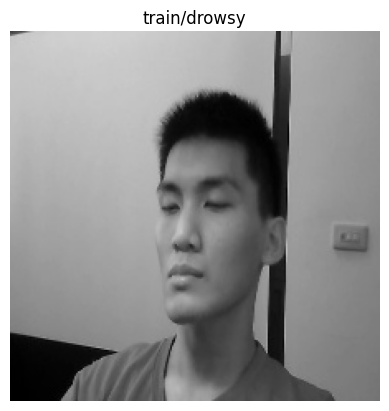

Image path: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/notdrowsy/001_noglasses_nonsleepyCombination_674_notdrowsy.jpg
Shape: (224, 224, 3)
Min pixel: 0 Max pixel: 255


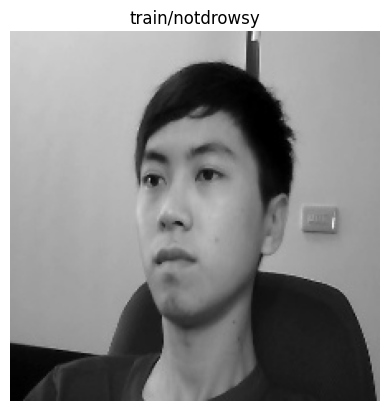

Image path: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/val/drowsy/002_glasses_yawning_643_drowsy.jpg
Shape: (224, 224, 3)
Min pixel: 0 Max pixel: 255


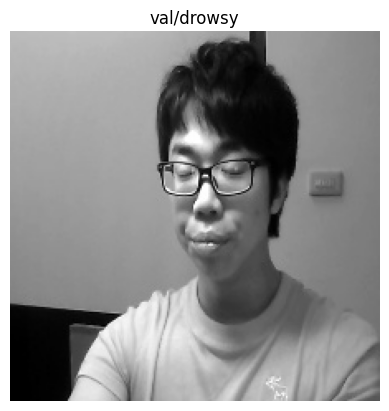

Image path: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/test/notdrowsy/001_glasses_nonsleepyCombination_2479_notdrowsy.jpg
Shape: (224, 224, 3)
Min pixel: 0 Max pixel: 255


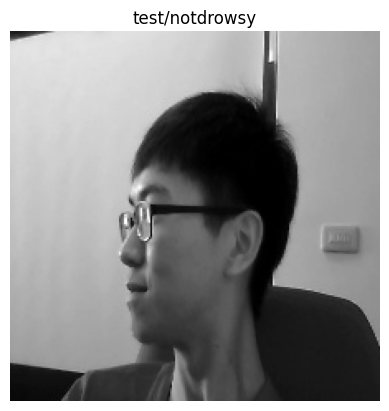

In [ ]:
def load_random_image(split, cls):
    folder = os.path.join(BASE, split, cls)
    file = np.random.choice(os.listdir(folder))
    path = os.path.join(folder, file)

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print("Image path:", path)
    print("Shape:", img.shape)
    print("Min pixel:", img.min(), "Max pixel:", img.max())

    plt.imshow(img)
    plt.title(f"{split}/{cls}")
    plt.axis("off")
    plt.show()

# test on a few random samples
load_random_image("train", "drowsy")
load_random_image("train", "notdrowsy")
load_random_image("val", "drowsy")
load_random_image("test", "notdrowsy")


In [3]:
import os

Loaded:
 Train: 46564
 Val:   9978
 Test:  9979


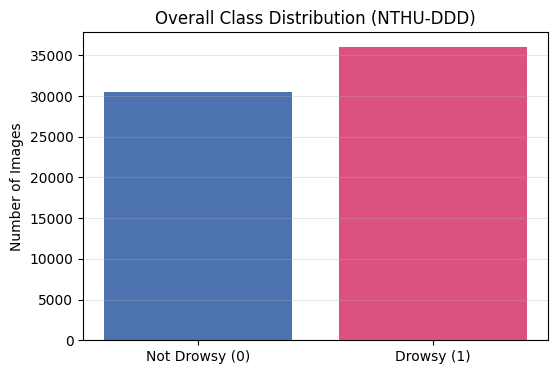

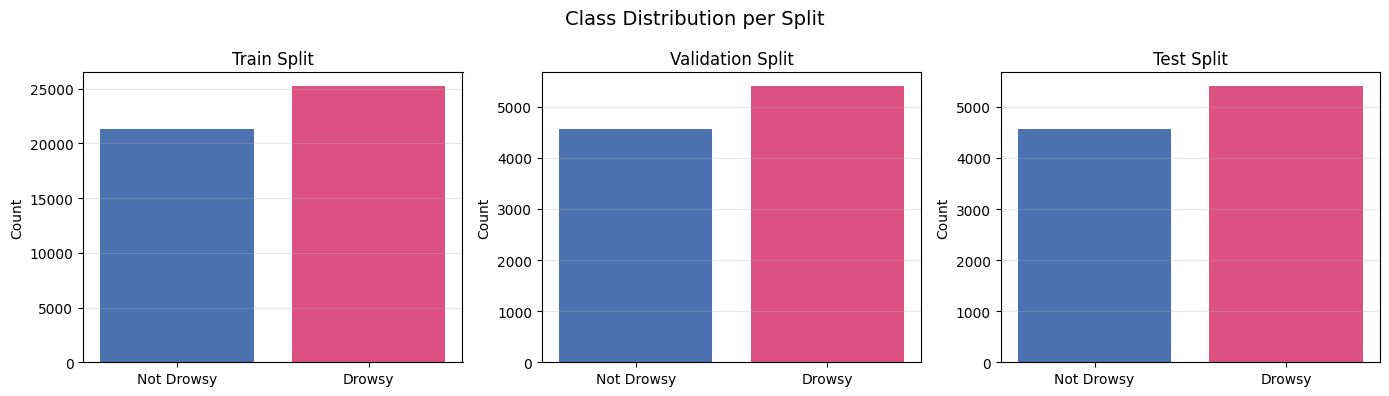


Train Split:
 Total: 46564
 Not Drowsy: 21343  (45.84%)
 Drowsy:     25221  (54.16%)

Validation Split:
 Total: 9978
 Not Drowsy: 4574  (45.84%)
 Drowsy:     5404  (54.16%)

Test Split:
 Total: 9979
 Not Drowsy: 4574  (45.84%)
 Drowsy:     5405  (54.16%)

Overall Split:
 Total: 66521
 Not Drowsy: 30491  (45.84%)
 Drowsy:     36030  (54.16%)


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1) LOAD METADATA CSV FILES
# ---------------------------------------------
BASE = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"

train_df = pd.read_csv(f"{BASE}/train_labels.csv")
val_df   = pd.read_csv(f"{BASE}/val_labels.csv")
test_df  = pd.read_csv(f"{BASE}/test_labels.csv")

print("Loaded:")
print(" Train:", len(train_df))
print(" Val:  ", len(val_df))
print(" Test: ", len(test_df))

# ---------------------------------------------
# 2) DEFINE PLOTTING FUNCTIONS
# ---------------------------------------------

def plot_class_distribution(df, title="Class Distribution"):
    """
    Plots a simple bar chart for class counts.
    Label: 0 = not drowsy, 1 = drowsy
    """
    counts = df['label'].value_counts().sort_index()
    labels = ["Not Drowsy (0)", "Drowsy (1)"]

    plt.figure(figsize=(6,4))
    plt.bar(labels, counts, color=["#4C72B0", "#DD5182"])
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.grid(axis="y", alpha=0.3)
    plt.show()


def plot_split_class_distribution(train_df, val_df, test_df):
    """
    Plots class distributions for train, val, test splits side-by-side.
    """
    splits = {
        "Train": train_df,
        "Validation": val_df,
        "Test": test_df
    }

    plt.figure(figsize=(14,4))

    for i, (name, df) in enumerate(splits.items(), 1):
        counts = df['label'].value_counts().sort_index()
        labels = ["Not Drowsy", "Drowsy"]

        plt.subplot(1, 3, i)
        plt.bar(labels, counts, color=["#4C72B0","#DD5182"])
        plt.title(f"{name} Split")
        plt.ylabel("Count")
        plt.grid(axis="y", alpha=0.3)

    plt.suptitle("Class Distribution per Split", fontsize=14)
    plt.tight_layout()
    plt.show()


# ---------------------------------------------
# 3) PLOT GRAPHS
# ---------------------------------------------

# Overall (using all splits combined)
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
plot_class_distribution(combined_df, title="Overall Class Distribution (NTHU-DDD)")

# Split-wise plots
plot_split_class_distribution(train_df, val_df, test_df)


# ---------------------------------------------
# 4) PRINT NUMERIC SUMMARY (Optional)
# ---------------------------------------------
def print_summary(df, name):
    n_total = len(df)
    n_not   = (df['label'] == 0).sum()
    n_yes   = (df['label'] == 1).sum()

    print(f"\n{name} Split:")
    print(f" Total: {n_total}")
    print(f" Not Drowsy: {n_not}  ({n_not/n_total:.2%})")
    print(f" Drowsy:     {n_yes}  ({n_yes/n_total:.2%})")

print_summary(train_df, "Train")
print_summary(val_df, "Validation")
print_summary(test_df, "Test")
print_summary(combined_df, "Overall")
